In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
import sys
import plot_settings
import matplotlib as mpl
import networkx as nx
import matplotlib.ticker as tk
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif']= 'STIXGeneral'
mpl.rcParams['mathtext.fontset']= 'stix'
mpl.rcParams['font.size']= 24

def read_gset(path: str):
    with open(path) as infile:
        G = nx.Graph()
        edges = []
        offset = 0 if '.gset' in path else 1
        nodes, n_edges = map(int, infile.readline().strip().split())
        const = 0
        J = np.zeros((nodes, nodes))
        for line in infile:
            args = line.strip().split()
            u, v = map(int, args[:2])
            edges.append((u-offset, v-offset))
        # h /= J.abs().max()
        # J /= J.abs().max()
        G.add_nodes_from(range(nodes))
        G.add_edges_from(edges)
        return G


In [3]:
pt_df_timing = pd.read_csv('../data/pt_timings.csv').set_index('graph')
kerberos_df_timing = pd.read_csv('../data/kerberos_gset.csv').set_index('graph')
brim_df_timing = pd.read_csv('../data/set_ttt_full_2000.csv').query('size==2000 and target == 0.99').rename(columns=dict(TTT='time'))[['graph', 'time']].set_index('graph')
kerberos_df_timing['Solver'] = 'Kerberos'
brim_df_timing['Solver'] = 'BRIM'
kerberos_df_timing['time'] =  pt_df_timing['time'] / kerberos_df_timing['time']
brim_df_timing['time'] =  pt_df_timing['time'] / brim_df_timing['time']
kerberos_df_timing =kerberos_df_timing.loc[~kerberos_df_timing['time'].isnull()]
brim_df_timing =brim_df_timing.loc[~brim_df_timing['time'].isnull()]
compdf = pd.concat([brim_df_timing.reset_index(), kerberos_df_timing.reset_index()]).reset_index(drop=True)

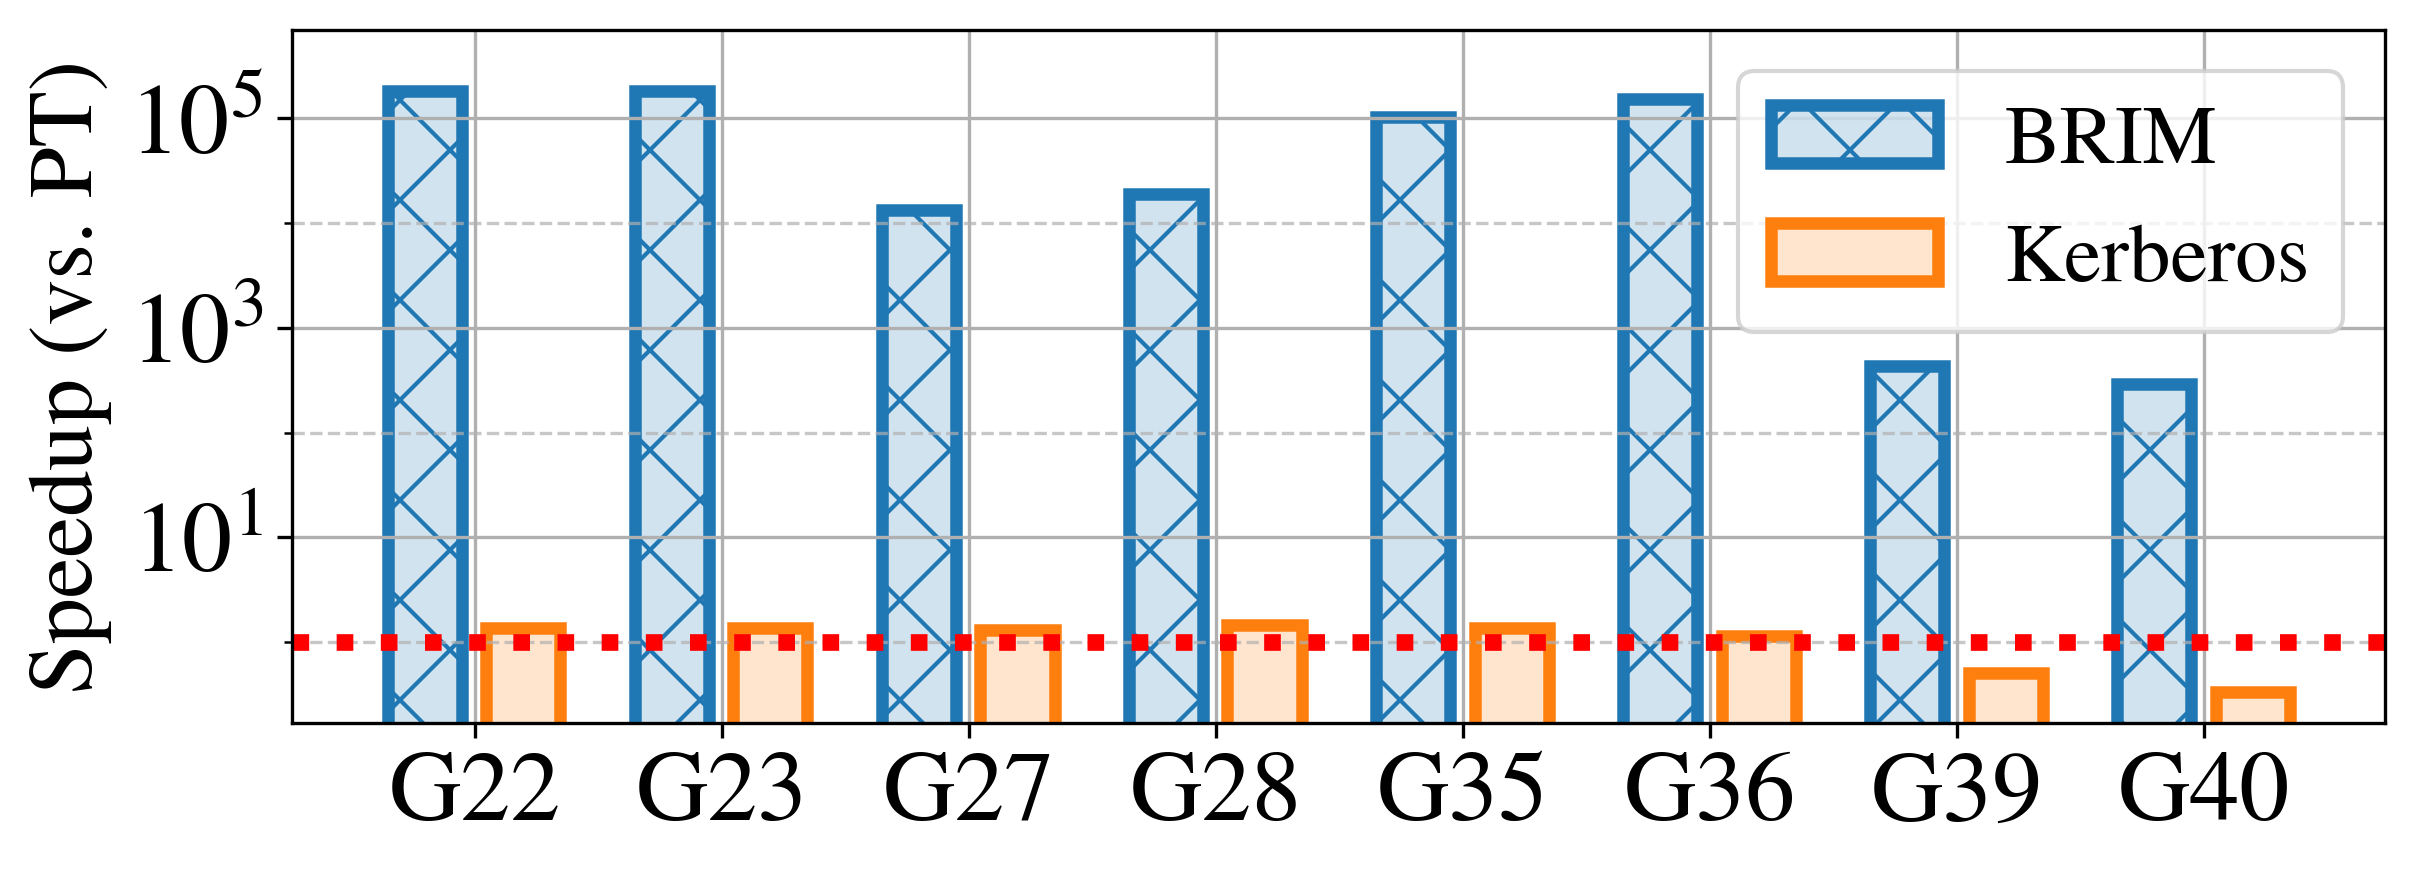

In [4]:
from matplotlib.ticker import LogLocator, NullFormatter
fig, ax = plt.subplots(figsize=(9, 3))

xticklabels = []
palette = sns.color_palette()
width=0.3
offset = -width *1.35/ 2
compdf = compdf.sort_values(by='graph')
linestyles = ['x', '']
for i, (s, sdf) in enumerate(compdf.groupby('Solver', sort=False)):
    ax.bar(x=np.arange(len(sdf['graph'])) + offset, 
           height=sdf['time'],
           edgecolor=palette[i],
           facecolor=(*palette[i], 0.2),
           linewidth=3, 
           width=width, 
           label=s, 
        #    hatch_linewidth=3,
           hatch=linestyles[i])
    xticklabels.append(s)
    offset += width + 0.1
ax.legend(fontsize=20)
ax.set_xticks(range(len(compdf['graph'].unique())))
ax.set_xticklabels(compdf['graph'].str.replace('G0', 'G').unique(), rotation=0)
ax.set_ylabel('Speedup (vs. PT)', fontdict={"size": 22})
ax.axhline(1, color='red', linestyle='dotted', linewidth=4)
ax.set_yscale('log')
ax.set_ylim(ax.get_ylim()[0], ax.get_ylim()[1]*2)
ax.yaxis.set_major_locator(LogLocator(base=10, subs=[1], numticks=4))
ax.yaxis.set_minor_locator(LogLocator(base=10, subs=[1], numticks=6))
ax.yaxis.set_minor_formatter(NullFormatter())
ax.grid(which='major')
ax.grid(which='minor', linestyle='--', alpha=0.7)
fig.savefig('../figures/fig_2_kerberos_motivation.pdf', bbox_inches='tight')
